In [1]:
import torch
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.preprocessing import ImdbDatabase
from src.model import TextClassifierTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
max_len = 100
batch_size = 32
num_words = 5000
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
imdb_database = ImdbDatabase(data_file_name='data/imdbdatabase.csv',  num_words = num_words, max_len=max_len, batch_size = batch_size, device = device)
train_loader, val_loader, test_loader = imdb_database.load_data()

In [3]:
# Les paramètres d'entrainement du Model teacher
# torch._C._set_nested_tensor(False)
print(device)
d_out: int=2
n_head: int=2
d_model: int=64
epochs: int=300
dropout: float=0.75
num_embeddings: int=5000
num_encoder_layers: int=1
dim_feedforward: int = 1 * d_model

clf_model = TextClassifierTransformer(vocab_size=num_embeddings, dim_feedforward=dim_feedforward, output_dim=d_out, num_layers=num_encoder_layers, n_head=n_head, d_model=d_model, dropout=dropout)
criterion = nn.CrossEntropyLoss()
clf_model.load_state_dict(torch.load('models/text_classifier_model_pool.pth'))

mps


<All keys matched successfully>

In [4]:
loss_tot = 0
correct = 0
targets = []
predicteds = []

device = torch.device("cpu" )
with torch.no_grad():  # Pas de calcul des gradients
    clf_model.eval()  # Mode évaluation
    clf_model.to(device)
    for x, y, mask in test_loader:  # Traitement par batch
        y = y.to(device)
        x = x.to(device)
        mask = mask.to(device).bool()
        # Prediction probabilities
        outputs = clf_model(x, mask)
        # Compute loss
        loss = criterion(outputs, y)
        # Prediction
        predicted = torch.argmax(outputs, dim=1)  
        correct += (predicted == y).sum().item() 
        targets.extend(y.cpu().numpy().reshape(-1))
        predicteds.extend(predicted.detach().cpu().numpy().reshape(-1))
        # Loss summation
        loss_tot += loss.item()  

# Compute Accuracy
accuracy = 100 * correct / len(test_loader.dataset)
# Display test statistics
print(f'Loss: {loss_tot / len(test_loader)}') 
print(f'Accuracy: {accuracy}%') 

Loss: 0.31824053906732136
Accuracy: 89.19860627177701%


In [5]:
print(classification_report(targets, predicteds, digits=2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       260
           1       0.89      0.91      0.90       314

    accuracy                           0.89       574
   macro avg       0.89      0.89      0.89       574
weighted avg       0.89      0.89      0.89       574



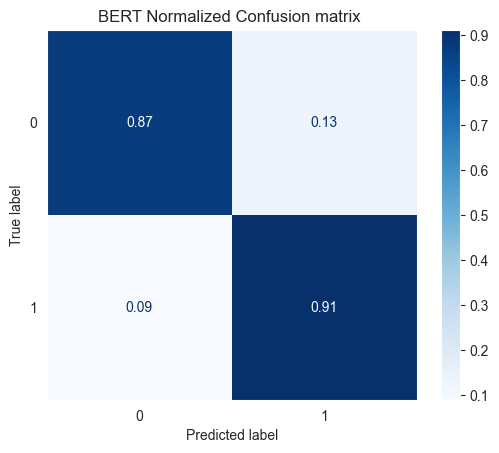

In [7]:
# BERT:
clf_classes = [i for i in range(2)]
conf_mat_norm = confusion_matrix(targets, predicteds, normalize='true', labels=clf_classes)
# Afficher la matrice avec matplotlib
disp_norm = ConfusionMatrixDisplay(confusion_matrix=conf_mat_norm, display_labels=clf_classes)
disp_norm.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("BERT Normalized Confusion matrix ")
plt.grid(False)
plt.show()